# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [1]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [7]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Check the shape of your data**

In [8]:
spaceship.shape

(8693, 14)

**Check for data types**

In [9]:
spaceship.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

**Check for missing values**

In [10]:
spaceship.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

There are multiple strategies to handle missing data

- Removing all rows or all columns containing missing data.
- Filling all missing values with a value (mean in continouos or mode in categorical for example).
- Filling all missing values with an algorithm.

For this exercise, because we have such low amount of null values, we will drop rows containing any missing value. 

In [11]:
spaceship_clean = spaceship.dropna()

- **Cabin** is too granular - transform it in order to obtain {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

In [12]:
spaceship_clean["Cabin"] = spaceship_clean["Cabin"].str[0]

/var/folders/js/q_xy_83s3tv43tdy3vzvblrw0000gn/T/ipykernel_24605/3909548814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spaceship_clean["Cabin"] = spaceship_clean["Cabin"].str[0]


In [13]:
spaceship_clean.loc[:, "Cabin"] = spaceship_clean["Cabin"].str[0]

- Drop PassengerId and Name

In [14]:
spaceship_clean = spaceship_clean.drop(columns=["PassengerId", "Name"])

- For non-numerical columns, do dummies.

In [15]:
categorical_cols = spaceship_clean.select_dtypes(include="object").columns
categorical_cols

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'], dtype='object')

In [16]:
spaceship_clean = pd.get_dummies(
    spaceship_clean,
    columns=categorical_cols,
    drop_first=True
)


In [17]:
spaceship_clean

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,True,False,False,False,False,False,False,False,True,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,True,False,False,False,False,False,False,False,False,False,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,True,False,False,False,False,False,False,False,False,False,False,True,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False,True,False,True,False,False
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,False,False,False,False,False,False,False,False,True,False,False,True,False
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,True,False,False,False,False,False,True,False,False,False,False,False,False


**Perform Train Test Split**

In [18]:
X = spaceship_clean.drop(columns=["Transported"])
y = spaceship_clean["Transported"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
X_train.shape

(5284, 19)

In [21]:
X_test.shape

(1322, 19)

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
std_scaler = StandardScaler()

In [24]:
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

In [25]:
X_train_scaled.shape

(5284, 19)

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def report_classification_results(model, X_test, y_test):
    """
    Plots confusion matrix and prints classification metrics
    """

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("📊 Classification Metrics")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure()
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()


- Bagging and Pasting

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=5,weights="distance")

In [28]:
bagging_clf = BaggingClassifier(
    estimator=knn,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagging_clf.fit(X_train_scaled, y_train)


,estimator,KNeighborsCla...ts='distance')
,n_estimators,100
,max_samples,0.8
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


In [29]:
pasting_clf = BaggingClassifier(
    estimator=knn,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=False,  # ✅ Pasting = sampling WITHOUT replacement
    n_jobs=-1,
    random_state=42
)

pasting_clf.fit(X_train_scaled, y_train)

,estimator,KNeighborsCla...ts='distance')
,n_estimators,100
,max_samples,0.8
,max_features,1.0
,bootstrap,False
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


📊 Classification Metrics
Accuracy : 0.781
Precision: 0.774
Recall   : 0.796
F1-score : 0.784

Detailed Classification Report:

              precision    recall  f1-score   support

       False       0.79      0.77      0.78       661
        True       0.77      0.80      0.78       661

    accuracy                           0.78      1322
   macro avg       0.78      0.78      0.78      1322
weighted avg       0.78      0.78      0.78      1322



<Figure size 640x480 with 0 Axes>

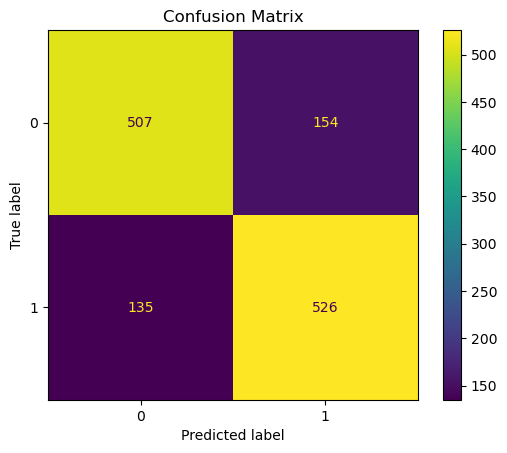

In [32]:
report_classification_results(bagging_clf, X_test_scaled, y_test)


📊 Classification Metrics
Accuracy : 0.787
Precision: 0.777
Recall   : 0.805
F1-score : 0.790

Detailed Classification Report:

              precision    recall  f1-score   support

       False       0.80      0.77      0.78       661
        True       0.78      0.80      0.79       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



<Figure size 640x480 with 0 Axes>

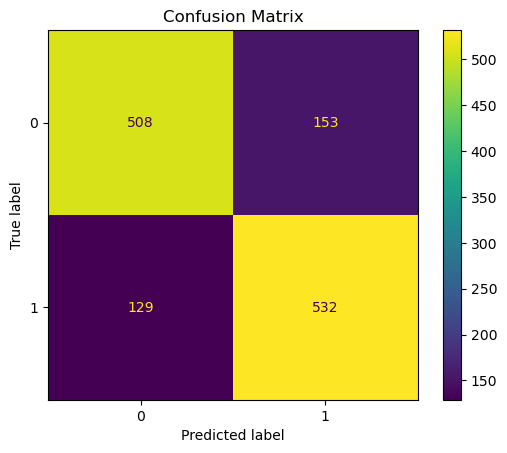

In [33]:

report_classification_results(pasting_clf, X_test_scaled, y_test)

- Random Forests

In [34]:
from sklearn.ensemble import RandomForestClassifier


In [39]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_features=None
)

rf_clf.fit(X_train_scaled, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


📊 Classification Metrics
Accuracy : 0.724
Precision: 0.743
Recall   : 0.685
F1-score : 0.713

Detailed Classification Report:

              precision    recall  f1-score   support

       False       0.71      0.76      0.73       661
        True       0.74      0.69      0.71       661

    accuracy                           0.72      1322
   macro avg       0.73      0.72      0.72      1322
weighted avg       0.73      0.72      0.72      1322



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

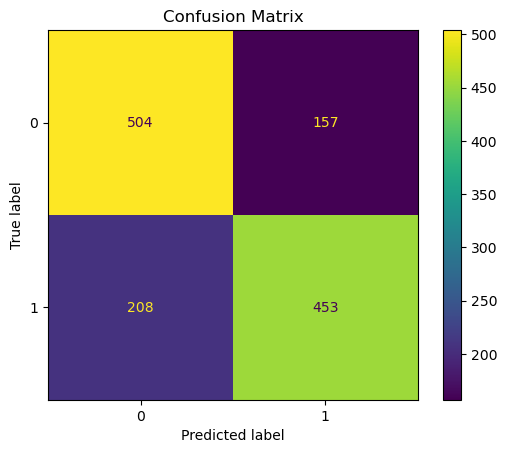

In [40]:
report_classification_results(rf_clf, X_test, y_test)


In [41]:
import pandas as pd

feature_importance = (
    pd.Series(rf_clf.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)

feature_importance.head(10)


CryoSleep_True             0.239521
Age                        0.157822
FoodCourt                  0.106653
VRDeck                     0.103065
Spa                        0.098844
ShoppingMall               0.085782
RoomService                0.078887
Cabin_G                    0.045517
Cabin_E                    0.020029
Destination_TRAPPIST-1e    0.016247
dtype: float64

- Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingClassifier


In [43]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

gb_clf.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


📊 Classification Metrics
Accuracy : 0.788
Precision: 0.763
Recall   : 0.837
F1-score : 0.798

Detailed Classification Report:

              precision    recall  f1-score   support

       False       0.82      0.74      0.78       661
        True       0.76      0.84      0.80       661

    accuracy                           0.79      1322
   macro avg       0.79      0.79      0.79      1322
weighted avg       0.79      0.79      0.79      1322



<Figure size 640x480 with 0 Axes>

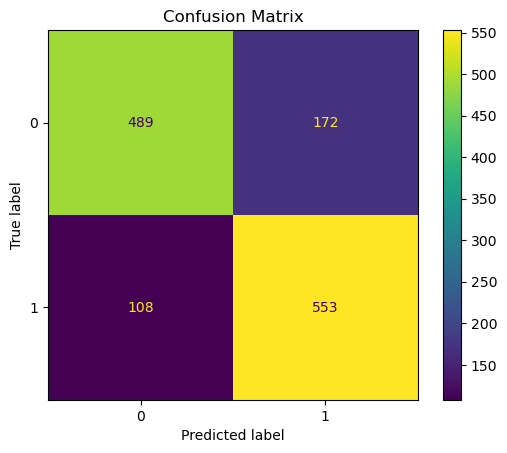

In [44]:
report_classification_results(gb_clf, X_test, y_test)


In [45]:

gb_importance = (
    pd.Series(gb_clf.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)

gb_importance.head(10)


CryoSleep_True       0.364322
Spa                  0.113884
VRDeck               0.113543
RoomService          0.106168
FoodCourt            0.086853
Cabin_G              0.056185
ShoppingMall         0.042684
Age                  0.039250
HomePlanet_Europa    0.025730
Cabin_E              0.023473
dtype: float64

- Adaptive Boosting

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


In [47]:
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)


,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,200
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


📊 Classification Metrics
Accuracy : 0.784
Precision: 0.801
Recall   : 0.755
F1-score : 0.777

Detailed Classification Report:

              precision    recall  f1-score   support

       False       0.77      0.81      0.79       661
        True       0.80      0.75      0.78       661

    accuracy                           0.78      1322
   macro avg       0.78      0.78      0.78      1322
weighted avg       0.78      0.78      0.78      1322



<Figure size 640x480 with 0 Axes>

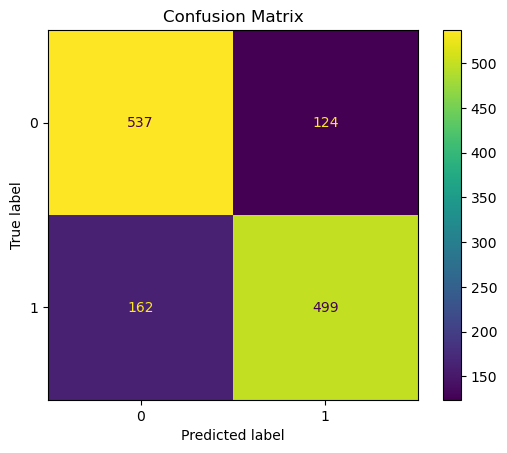

In [48]:
report_classification_results(ada_clf, X_test, y_test)


In [49]:
ada_importance = (
    pd.Series(ada_clf.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)

ada_importance.head(10)


Spa                        0.297229
VRDeck                     0.286526
CryoSleep_True             0.083150
RoomService                0.082914
HomePlanet_Europa          0.079686
FoodCourt                  0.070263
ShoppingMall               0.046107
Cabin_G                    0.020738
Age                        0.018494
Destination_TRAPPIST-1e    0.010037
dtype: float64

Which model is the best and why?

Gradient boosting is the best model as has better metrics